<img src="https://raw.githubusercontent.com/Kmilo29/repository/main/images/proyecto.png" ><br>

# MINE-4101: Ciencia de Datos Aplicada
## Universidad de los Andes
Segundo Semestre - 2023


## Empresa OPAIN S.A.


## Integrantes

* Sebastian Arango Loaiza
* Nicolas Adolfo Castillo Betancourt
* Johan David Rodriguez Portela
* Ivan Camilo Delgado Cañon

# Librerias

In [1]:
%load_ext autoreload
%autoreload 2
import pickle

import pandas as pd
import univariate_utils
import multivariate_utils

from exploration import load_datasets
from model_pruning import (
    assign_dataset_configs,
    transform_datasets,
    remove_high_colineality_columns,
    train_base_dataset_models,
    train_best_features_models
)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Constantes

In [2]:
ORIGINAL_METRICS_FILE = "results/summary.csv"
EXTENDED_METRICS_FILE = "extended_data_results/summary.csv"

In [3]:
OUTPUT_MODELS_FILE = "final_models/trained_no_colineal_models.pkl"

In [4]:
NUM_TRANSFORMS_TO_IGNORE = ["powerTransformer", "polynomialFeatures"]

In [5]:
SELECTION_METRIC = "R2"
LOWER_IS_BEST = False

In [6]:
MAX_COLINEALITY = 0.90

# Utils

In [7]:
def filter_best_models(df: pd.DataFrame) -> pd.DataFrame:
    """Filters best model config by Marca and selected metric in test"""
    df_test = df[
        df["split"] == "test"
    ].sort_values(SELECTION_METRIC, ascending=LOWER_IS_BEST)
    
    df_best = df_test.groupby("dataset").head(1).sort_values("dataset")
    
    return df_best

# Ejecucion

## Lectura de metricas

In [8]:
df_original = pd.read_csv(ORIGINAL_METRICS_FILE)
df_extended = pd.read_csv(EXTENDED_METRICS_FILE)

### Ignorando polynomial features por dificultad de interpretacion
Se procede a eliminar del análisis ciertas transformaciones de datos en nuestros DataFrames, df_original y df_extended. Estas transformaciones específicas están definidas en una lista llamada NUM_TRANSFORMS_TO_IGNORE. La razón es para enfocarnos en un subconjunto específico de transformaciones que son más relevantes o más fáciles de interpretar en nuestro análisis. Al hacerlo, podemos simplificar nuestro conjunto de datos y centrarnos en lo que realmente importa para nuestro análisis. Esto nos ayuda a tener una comprensión más clara de los resultados y a tomar decisiones más informadas

In [9]:
for trans in NUM_TRANSFORMS_TO_IGNORE:
    df_original = df_original[
        df_original["num_config"] != trans
    ].copy(deep=True)
    df_extended = df_extended[
        df_extended["num_config"] != trans
    ].copy(deep=True)    

In [10]:
df_original.head(5)

,split,MSE,MAE,R2,MAPE,dataset,num_config,scat_config,lcat_config,model,columns
0,train,7.877064e+15,6.983090e+07,0.412823,3.408574e+21,marca 1,minMaxScaler,oneHotEncoder__0.0,oneHotEncoder__0.0,linearRegression,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
1,test,8.051213e+15,7.102468e+07,0.401813,2.507123e+21,marca 1,minMaxScaler,oneHotEncoder__0.0,oneHotEncoder__0.0,linearRegression,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
4,train,2.587287e+12,1.230898e+06,0.972818,2.696271e+18,marca 9,standardScaler,oneHotEncoder__0.05,oneHotEncoder__0.05,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
5,test,3.002276e+13,4.165074e+06,0.681981,8.735012e+18,marca 9,standardScaler,oneHotEncoder__0.05,oneHotEncoder__0.05,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
8,train,4.459100e+16,1.637745e+08,0.336363,3.077236e+20,muelle,standardScaler,oneHotEncoder__0.05,oneHotEncoder__0.05,linearRegression,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."


In [11]:
df_extended.head(5)

,split,MSE,MAE,R2,MAPE,dataset,num_config,scat_config,lcat_config,model,columns
0,train,4.767205e+13,5.057843e+06,0.996447,1.951895e+20,marca 1,robustScaler,oneHotEncoder__0.0,featureHasher__2,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
1,test,1.004725e+15,2.110722e+07,0.923256,1.183147e+21,marca 1,robustScaler,oneHotEncoder__0.0,featureHasher__2,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
2,train,8.044843e+13,7.150972e+06,0.157021,3.885937e+19,marca 9,minMaxScaler,oneHotEncoder__0.05,featureHasher__2,linearRegression,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
3,test,8.092599e+13,7.153825e+06,0.146731,4.708324e+19,marca 9,minMaxScaler,oneHotEncoder__0.05,featureHasher__2,linearRegression,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
4,train,1.260002e+12,8.637393e+05,0.986797,2.730213e+18,marca 9,standardScaler,oneHotEncoder__0.05,oneHotEncoder__0.05,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."


# Filtrado de mejores resultados en test 
El modelo ampliado demuestra consistentemente un mejor rendimiento por marca en comparación con el modelo que utiliza solo las características originales. Sin embargo, este aumento en el rendimiento también se acompaña de una complejidad adicional, ya que ambos modelos tienen un número significativo de características. Para facilitar la interpretación de los resultados, se hace necesaria la eliminación de características, lo que implica identificar y retener solo las características más relevantes y significativas para el análisis. Esta estrategia de selección de características es esencial para garantizar que el modelo sea interpretable y permita una comprensión más clara de la influencia de cada característica en las predicciones.

In [12]:
df_original_best = filter_best_models(df_original)
df_original_best

,split,MSE,MAE,R2,MAPE,dataset,num_config,scat_config,lcat_config,model,columns
441,test,1.596505e+15,2.778621e+07,0.881383,6.257433e+20,marca 1,standardScaler,oneHotEncoder__0.05,oneHotEncoder__0.0,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
917,test,2.944826e+13,3.625213e+06,0.655584,5.061418e-01,marca 10,robustScaler,oneHotEncoder__0.05,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
869,test,2.787228e+14,1.254967e+07,0.775797,3.918242e-01,marca 2,minMaxScaler,oneHotEncoder__0.0,oneHotEncoder__0.0,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
429,test,9.084574e+14,2.256251e+07,0.756032,3.491769e-01,marca 3,robustScaler,oneHotEncoder__0.0,oneHotEncoder__0.05,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
595,test,2.028898e+14,1.000055e+07,0.655563,1.567375e+00,marca 5,robustScaler,oneHotEncoder__0.05,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
87,test,4.860306e+14,1.539156e+07,0.663141,3.270523e+19,marca 6,minMaxScaler,oneHotEncoder__0.0,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
139,test,2.888428e+13,3.891792e+06,0.593538,1.802702e+21,marca 7,minMaxScaler,oneHotEncoder__0.0,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
227,test,3.002276e+13,4.165074e+06,0.681981,8.735012e+18,marca 9,standardScaler,oneHotEncoder__0.05,oneHotEncoder__0.0,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
801,test,6.881388e+15,5.836895e+07,0.895409,2.075118e+19,muelle,robustScaler,oneHotEncoder__0.05,oneHotEncoder__0.0,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."


In [13]:
df_extended_best = filter_best_models(df_extended)
df_extended_best

,split,MSE,MAE,R2,MAPE,dataset,num_config,scat_config,lcat_config,model,columns
265,test,9.315888e+14,2.054666e+07,0.928842,1.153843e+21,marca 1,standardScaler,oneHotEncoder__0.0,oneHotEncoder__0.05,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
161,test,2.684137e+13,3.412393e+06,0.684748,4.795939e-01,marca 10,minMaxScaler,oneHotEncoder__0.0,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
963,test,2.199509e+14,1.107418e+07,0.825614,3.703004e-01,marca 2,minMaxScaler,oneHotEncoder__0.0,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
657,test,7.050922e+14,1.975757e+07,0.804904,2.971616e-01,marca 3,minMaxScaler,oneHotEncoder__0.05,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
183,test,1.963122e+14,9.879837e+06,0.650056,1.516551e+00,marca 5,robustScaler,oneHotEncoder__0.0,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
613,test,4.209651e+14,1.457378e+07,0.702632,2.998583e+19,marca 6,standardScaler,oneHotEncoder__0.0,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
1001,test,2.584761e+13,3.822018e+06,0.625202,1.716043e+21,marca 7,robustScaler,oneHotEncoder__0.0,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
631,test,2.150488e+13,3.502161e+06,0.773256,3.853363e+18,marca 9,robustScaler,oneHotEncoder__0.0,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
799,test,4.499722e+15,4.654834e+07,0.934495,3.489620e+19,muelle,robustScaler,oneHotEncoder__0.05,oneHotEncoder__0.0,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."


In [14]:
df_original_best["feature_set"] = "original"
df_extended_best["feature_set"] = "extended"

df_best_configs = filter_best_models(
    pd.concat([df_original_best, df_extended_best])
)

In [15]:
df_best_configs["feature_count"] = df_best_configs["columns"].apply(
    lambda x: len(eval(x))
)

In [16]:
df_best_configs

,split,MSE,MAE,R2,MAPE,dataset,num_config,scat_config,lcat_config,model,columns,feature_set,feature_count
265,test,9.315888e+14,2.054666e+07,0.928842,1.153843e+21,marca 1,standardScaler,oneHotEncoder__0.0,oneHotEncoder__0.05,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,175
161,test,2.684137e+13,3.412393e+06,0.684748,4.795939e-01,marca 10,minMaxScaler,oneHotEncoder__0.0,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,35
963,test,2.199509e+14,1.107418e+07,0.825614,3.703004e-01,marca 2,minMaxScaler,oneHotEncoder__0.0,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,35
657,test,7.050922e+14,1.975757e+07,0.804904,2.971616e-01,marca 3,minMaxScaler,oneHotEncoder__0.05,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,35
595,test,2.028898e+14,1.000055e+07,0.655563,1.567375e+00,marca 5,robustScaler,oneHotEncoder__0.05,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",original,20
613,test,4.209651e+14,1.457378e+07,0.702632,2.998583e+19,marca 6,standardScaler,oneHotEncoder__0.0,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,35
1001,test,2.584761e+13,3.822018e+06,0.625202,1.716043e+21,marca 7,robustScaler,oneHotEncoder__0.0,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,35
631,test,2.150488e+13,3.502161e+06,0.773256,3.853363e+18,marca 9,robustScaler,oneHotEncoder__0.0,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,35
799,test,4.499722e+15,4.654834e+07,0.934495,3.489620e+19,muelle,robustScaler,oneHotEncoder__0.05,oneHotEncoder__0.0,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,174


# Visualizando que influencia mas las metricas en test
Explorando cómo diferentes variables, como el conjunto de datos, la configuración numérica, las configuraciones escaladas y las codificadas, afectan una métrica específica que utilizamos para seleccionar modelos en nuestro conjunto de prueba. Verificando de esta manera, qué variables tienen un impacto más significativo en el rendimiento de nuestros modelos. Esta exploración nos ayuda a identificar las características que más influyen en la métrica de selección, lo que a su vez nos permite tomar decisiones más informadas para mejorar el rendimiento de nuestros modelos.

In [17]:
df_plot_metrics = df_extended[
    df_extended["split"] == "test"
].copy(deep=True)

In [18]:
df_plot_metrics["scat_config_type"] =  df_plot_metrics["scat_config"].apply(
    lambda x: x.split("__")[0]
)
df_plot_metrics["lcat_config_type"] =  df_plot_metrics["lcat_config"].apply(
    lambda x: x.split("__")[0]
)

****************************************************************************************************
dataset influence over R2


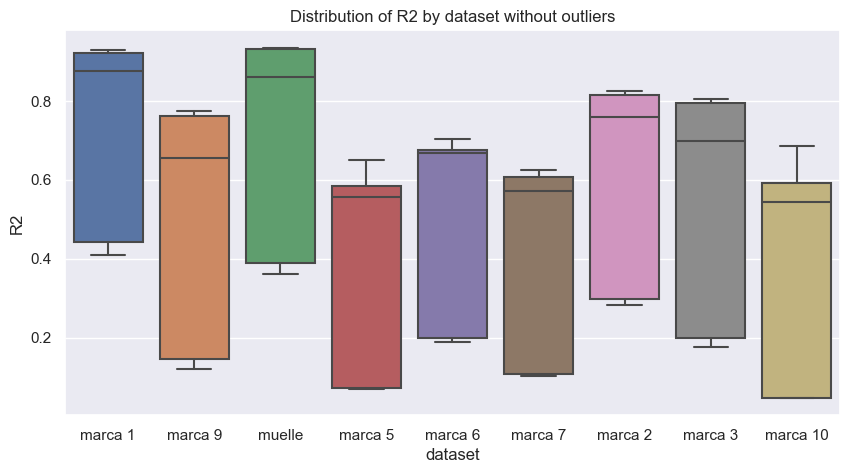

dataset,marca 1,marca 10,marca 2,marca 3,marca 5,marca 6,marca 7,marca 9,muelle
count,4.500000e+01,4.500000e+01,4.500000e+01,4.500000e+01,4.500000e+01,4.500000e+01,45.000000,4.500000e+01,4.500000e+01
mean,-2.278269e+51,-1.769792e+34,-4.921758e+27,-7.516343e+22,-3.718664e+49,-9.778328e+49,-1771.353232,-3.001521e+51,-1.492856e+26
std,1.057593e+52,4.563125e+34,2.250133e+28,1.792620e+23,1.132252e+50,3.243279e+50,5584.260910,7.669968e+51,4.140727e+26
min,-5.076801e+52,-1.336028e+35,-1.080236e+29,-5.909573e+23,-5.649020e+50,-1.525718e+51,-19442.283503,-2.987986e+52,-1.704726e+27
5%,-2.483399e+50,-1.322995e+35,-4.345534e+27,-4.644139e+23,-2.771242e+50,-4.023716e+50,-19442.283503,-2.215878e+52,-1.183406e+27
25%,4.430007e-01,4.808631e-02,2.976062e-01,2.004873e-01,7.256577e-02,1.983512e-01,0.107710,1.467312e-01,3.885274e-01
50%,8.758682e-01,5.440275e-01,7.587521e-01,6.976921e-01,5.564752e-01,6.668912e-01,0.572007,6.553998e-01,8.610497e-01
75%,9.221477e-01,5.929755e-01,8.138673e-01,7.952938e-01,5.851467e-01,6.762245e-01,0.606528,7.628247e-01,9.305899e-01
95%,9.288422e-01,6.824998e-01,8.222683e-01,8.035669e-01,6.482004e-01,6.998785e-01,0.618549,7.712337e-01,9.344457e-01
max,9.288422e-01,6.847477e-01,8.256143e-01,8.049036e-01,6.500562e-01,7.026315e-01,0.625202,7.732564e-01,9.344953e-01


****************************************************************************************************
num_config influence over R2


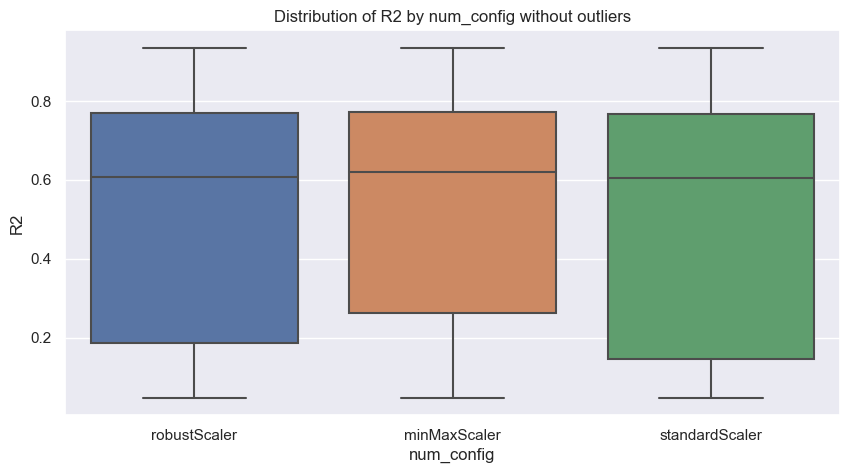

num_config,minMaxScaler,robustScaler,standardScaler
count,1.080000e+02,1.080000e+02,1.890000e+02
mean,-2.884881e+50,-1.121675e+51,-4.834209e+50
std,2.874975e+51,6.944752e+51,3.196173e+51
min,-2.987986e+52,-5.076801e+52,-2.215878e+52
5%,-4.127401e+27,-9.917167e+50,-2.255592e+50
25%,2.623459e-01,1.859891e-01,1.467312e-01
50%,6.185491e-01,6.065282e-01,6.042683e-01
75%,7.713602e-01,7.680502e-01,7.666360e-01
95%,9.237159e-01,9.260458e-01,9.288422e-01
max,9.341692e-01,9.344953e-01,9.344457e-01


****************************************************************************************************
scat_config influence over R2


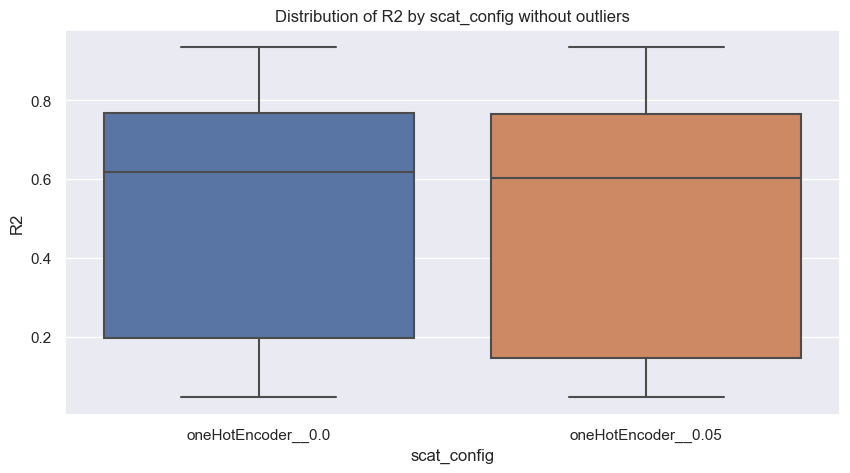

scat_config,oneHotEncoder__0.0,oneHotEncoder__0.05
count,2.160000e+02,1.890000e+02
mean,-4.919154e+50,-7.270394e+50
std,4.079614e+51,4.851002e+51
min,-5.076801e+52,-5.076801e+52
5%,-4.504424e+49,-2.724268e+50
25%,1.983512e-01,1.467312e-01
50%,6.178974e-01,6.042683e-01
75%,7.687195e-01,7.666360e-01
95%,9.247610e-01,9.282237e-01
max,9.344953e-01,9.344953e-01


****************************************************************************************************
lcat_config influence over R2


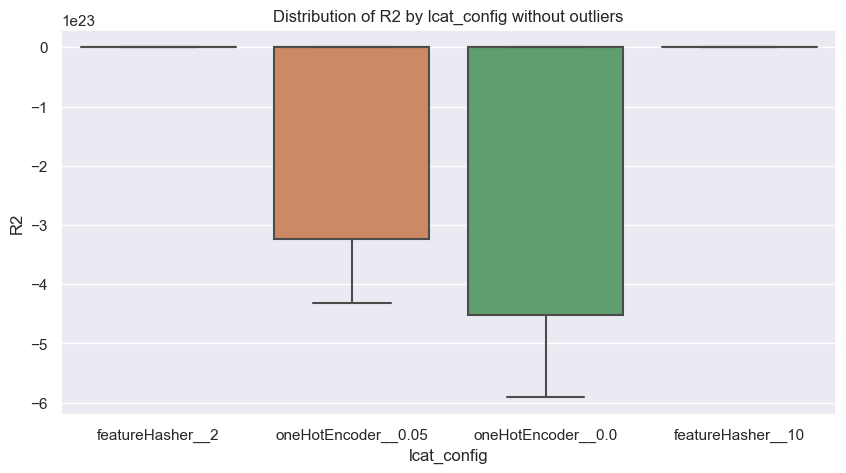

lcat_config,featureHasher__10,featureHasher__2,oneHotEncoder__0.0,oneHotEncoder__0.05
count,108.000000,108.000000,1.350000e+02,5.400000e+01
mean,0.557056,0.550806,-1.466525e+51,-8.459867e+50
std,0.281019,0.271603,7.166381e+51,4.219666e+51
min,0.048063,0.048086,-5.076801e+52,-2.215878e+52
5%,0.069407,0.072566,-3.551020e+51,-2.771242e+50
25%,0.282965,0.297606,-4.522509e+23,-3.239845e+23
50%,0.648744,0.607133,5.984120e-01,5.929755e-01
75%,0.780628,0.759799,7.666360e-01,7.627922e-01
95%,0.921503,0.923832,9.287245e-01,9.288422e-01
max,0.931156,0.931030,9.344953e-01,9.344457e-01


****************************************************************************************************
model influence over R2


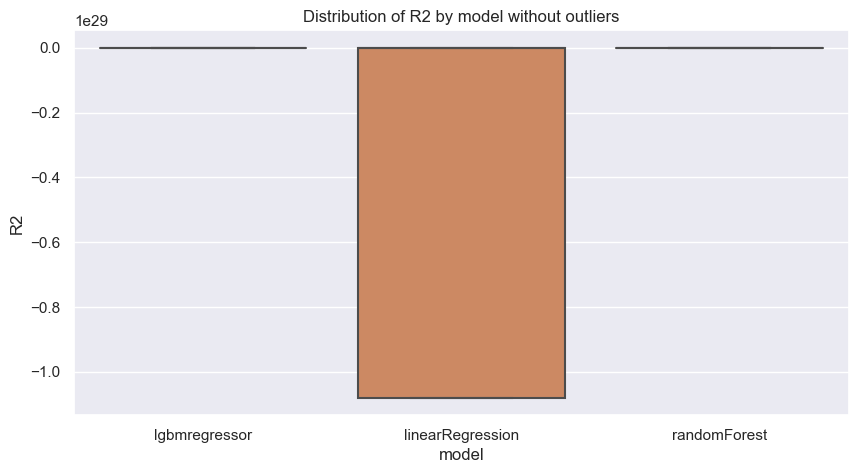

model,lgbmregressor,linearRegression,randomForest
count,135.000000,1.350000e+02,135.000000
mean,0.738027,-1.804920e+51,0.704700
std,0.137948,7.587663e+51,0.105675
min,0.538640,-5.076801e+52,0.549365
5%,0.544027,-1.244134e+52,0.555203
25%,0.604268,-1.080236e+29,0.645110
50%,0.766636,4.808631e-02,0.684748
75%,0.820325,1.891914e-01,0.770332
95%,0.932060,4.102988e-01,0.878023
max,0.934495,4.430007e-01,0.883480


In [19]:
for col in ["dataset", "num_config", "scat_config", "lcat_config", "model"]:
    print("*" * 100)
    print(f"{col} influence over {SELECTION_METRIC}")
    multivariate_utils.plot_distributions(
        df_plot_metrics,
        SELECTION_METRIC,
        col,
        (10, 5),
        "box",  # Puede ser hist o box
        False
    )
    multivariate_utils.make_column_non_graphic_analysis(
        df_plot_metrics,
        SELECTION_METRIC,
        col
    )

# Transformacion de datasets

In [20]:
datasets = assign_dataset_configs(df_best_configs)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34.33it/s]


In [21]:
datasets["muelle"].keys()

dict_keys(['X_train', 'X_test', 'y_train', 'y_test', 'config'])

In [22]:
for marca in datasets:
    print(marca)
    print(datasets[marca]["config"])

muelle
{'num_config': 'robustScaler', 'scat_config': ['oneHotEncoder', '0.05'], 'lcat_config': ['oneHotEncoder', '0.0'], 'model': 'lgbmregressor'}
marca 1
{'num_config': 'standardScaler', 'scat_config': ['oneHotEncoder', '0.0'], 'lcat_config': ['oneHotEncoder', '0.05'], 'model': 'lgbmregressor'}
marca 2
{'num_config': 'minMaxScaler', 'scat_config': ['oneHotEncoder', '0.0'], 'lcat_config': ['featureHasher', '10'], 'model': 'lgbmregressor'}
marca 3
{'num_config': 'minMaxScaler', 'scat_config': ['oneHotEncoder', '0.05'], 'lcat_config': ['featureHasher', '10'], 'model': 'lgbmregressor'}
marca 5
{'num_config': 'robustScaler', 'scat_config': ['oneHotEncoder', '0.05'], 'lcat_config': ['featureHasher', '10'], 'model': 'randomForest'}
marca 6
{'num_config': 'standardScaler', 'scat_config': ['oneHotEncoder', '0.0'], 'lcat_config': ['featureHasher', '10'], 'model': 'randomForest'}
marca 7
{'num_config': 'robustScaler', 'scat_config': ['oneHotEncoder', '0.0'], 'lcat_config': ['featureHasher', '10'

In [23]:
datasets_trans = transform_datasets(datasets)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.49it/s]


In [24]:
(
    datasets_trans["muelle"]["X_train"].shape,
    datasets_trans["muelle"]["X_test"].shape,
    len(datasets_trans["muelle"]["columns"])
)

((40267, 174), (10067, 174), 174)

# Eliminacion de columnas con alta colinealidad

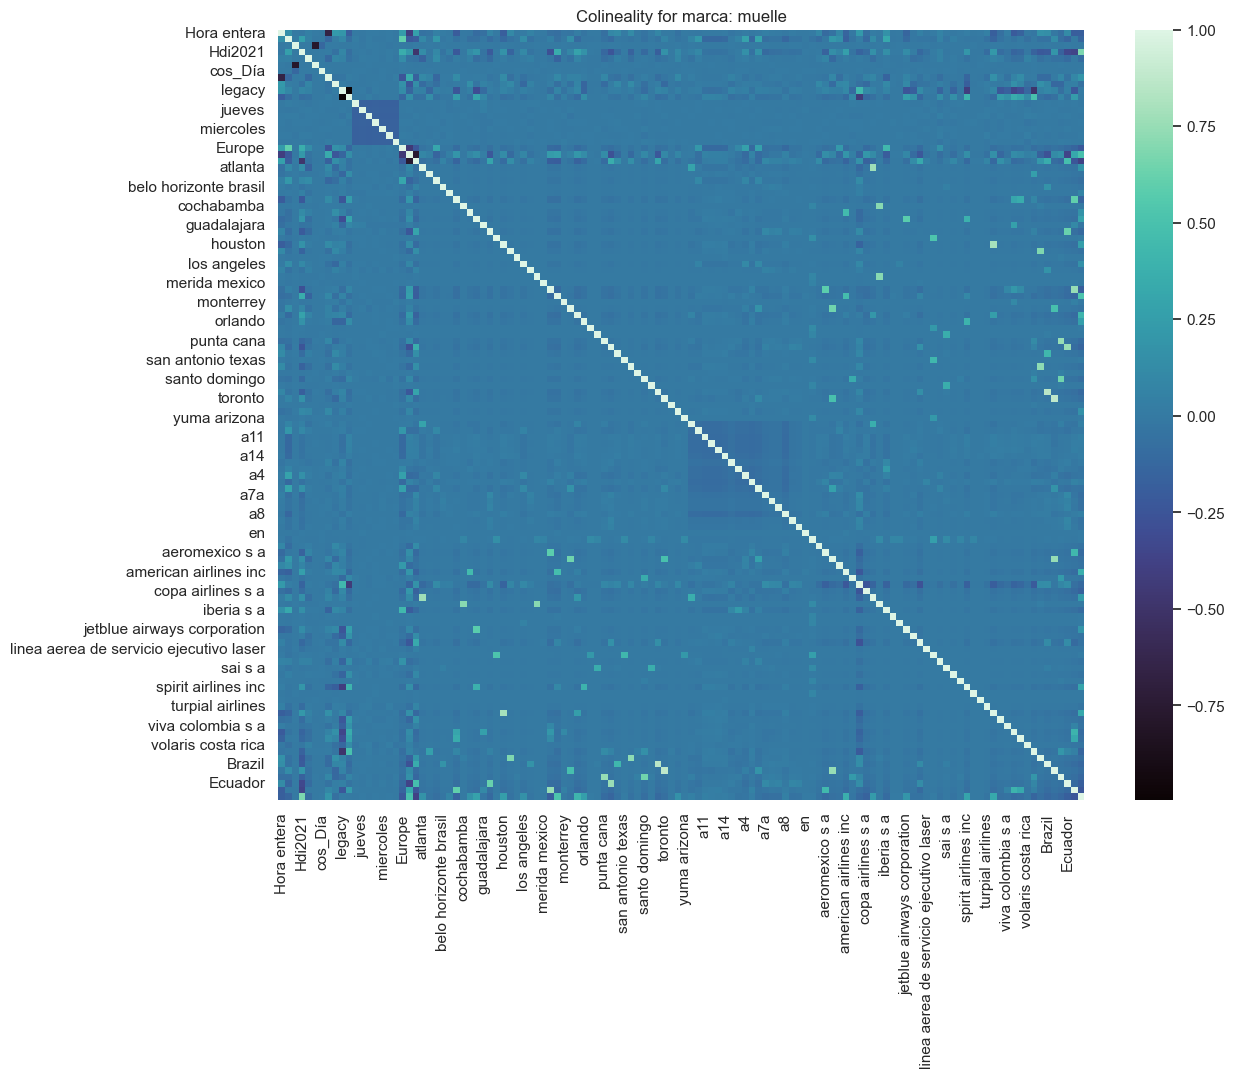

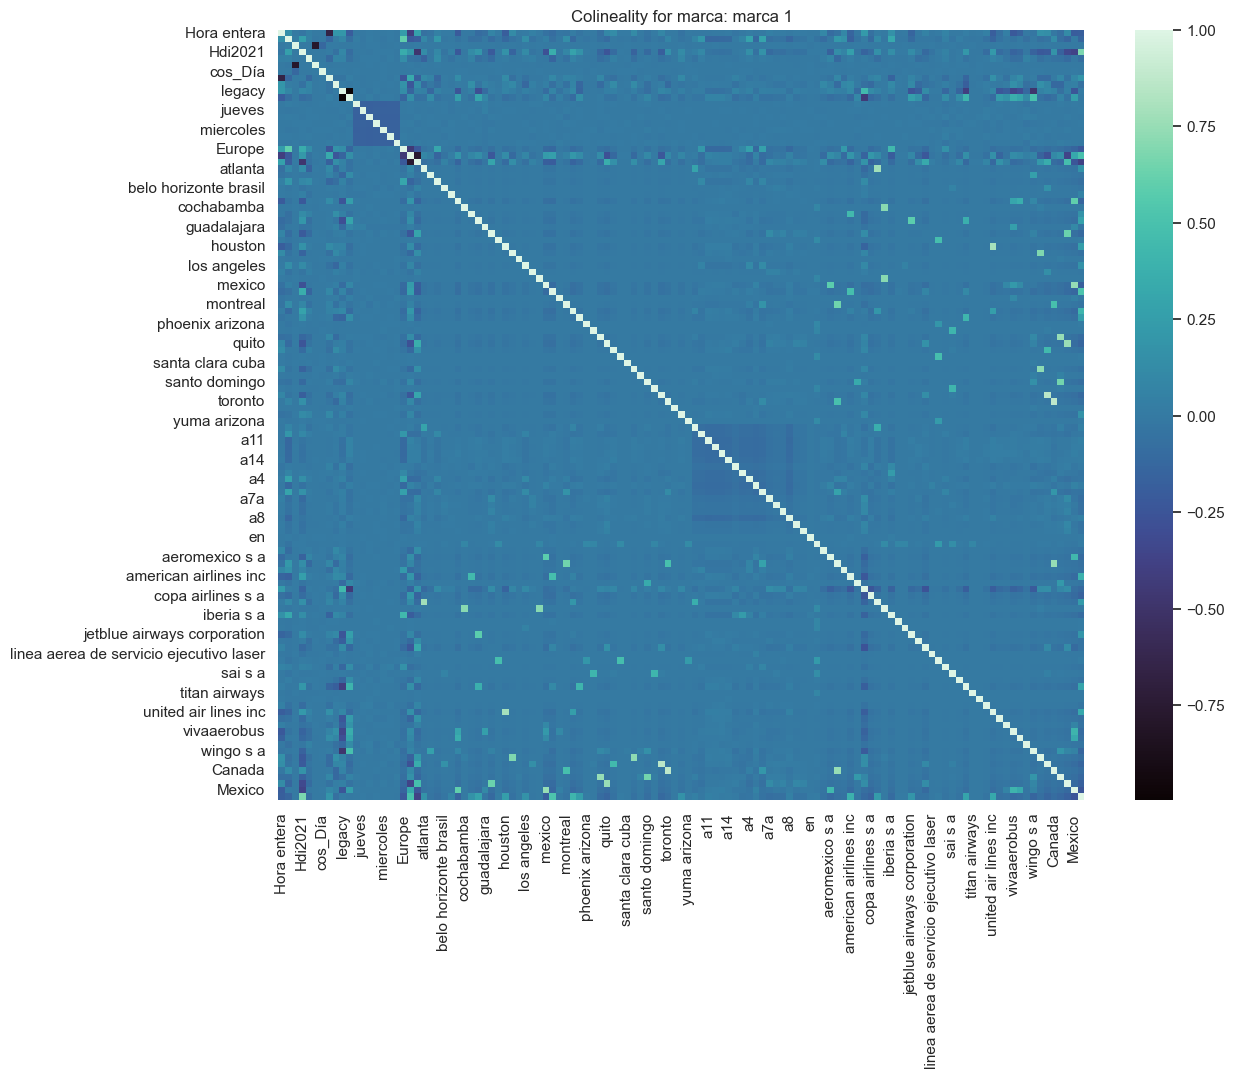

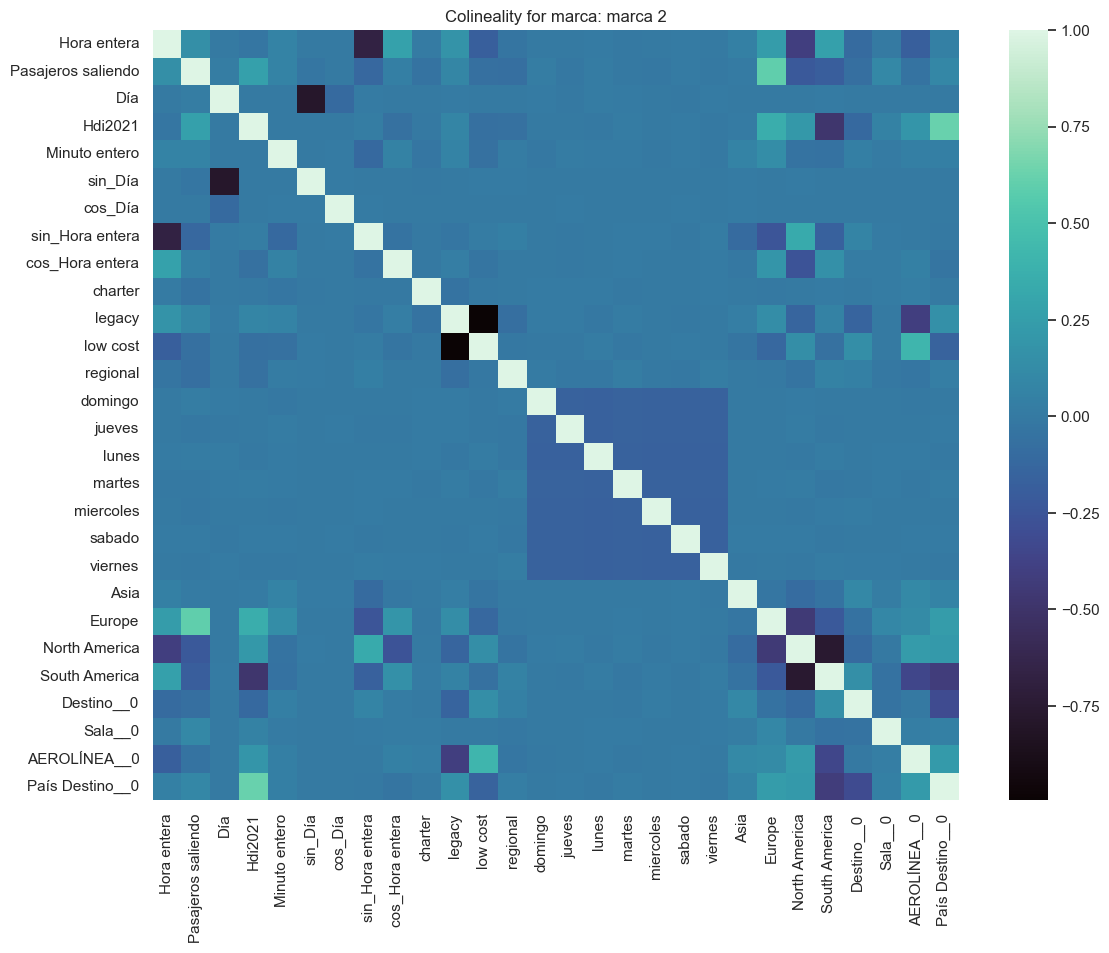

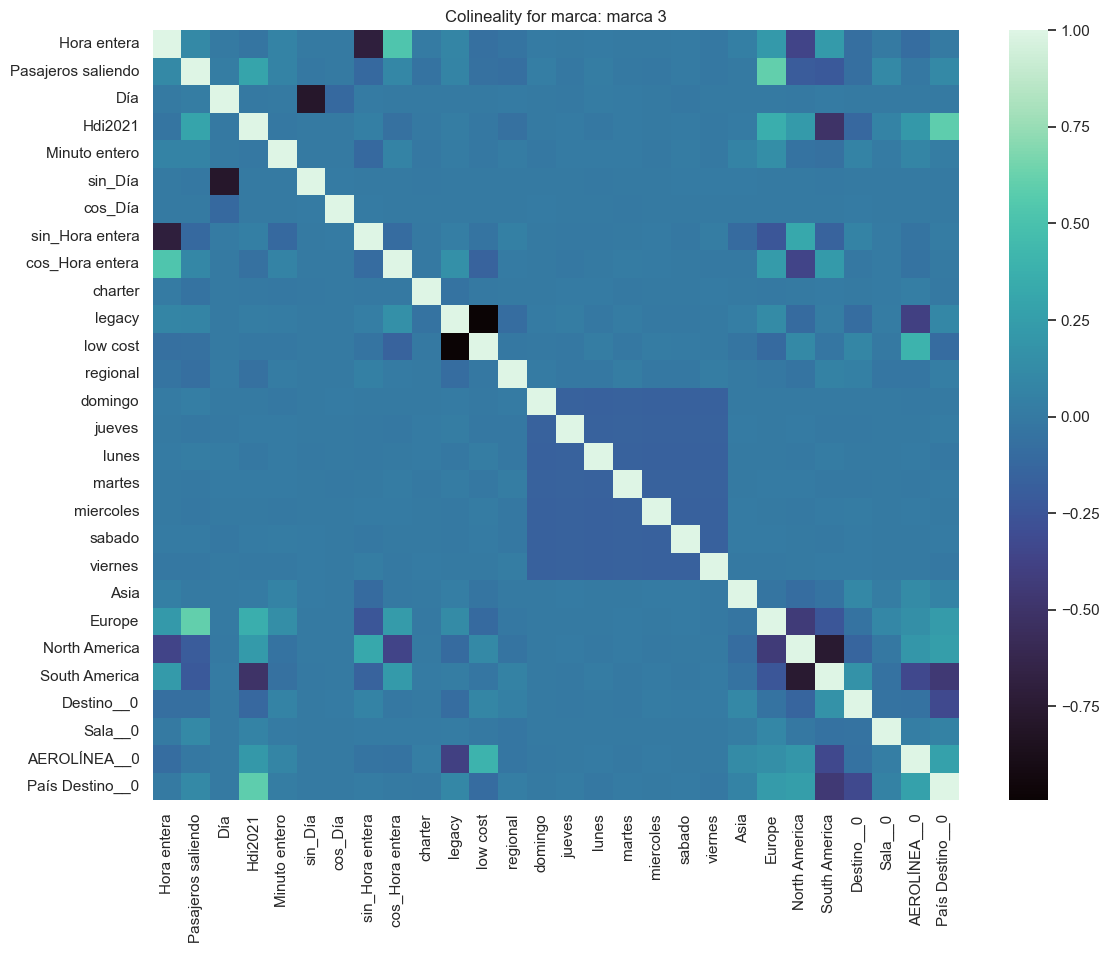

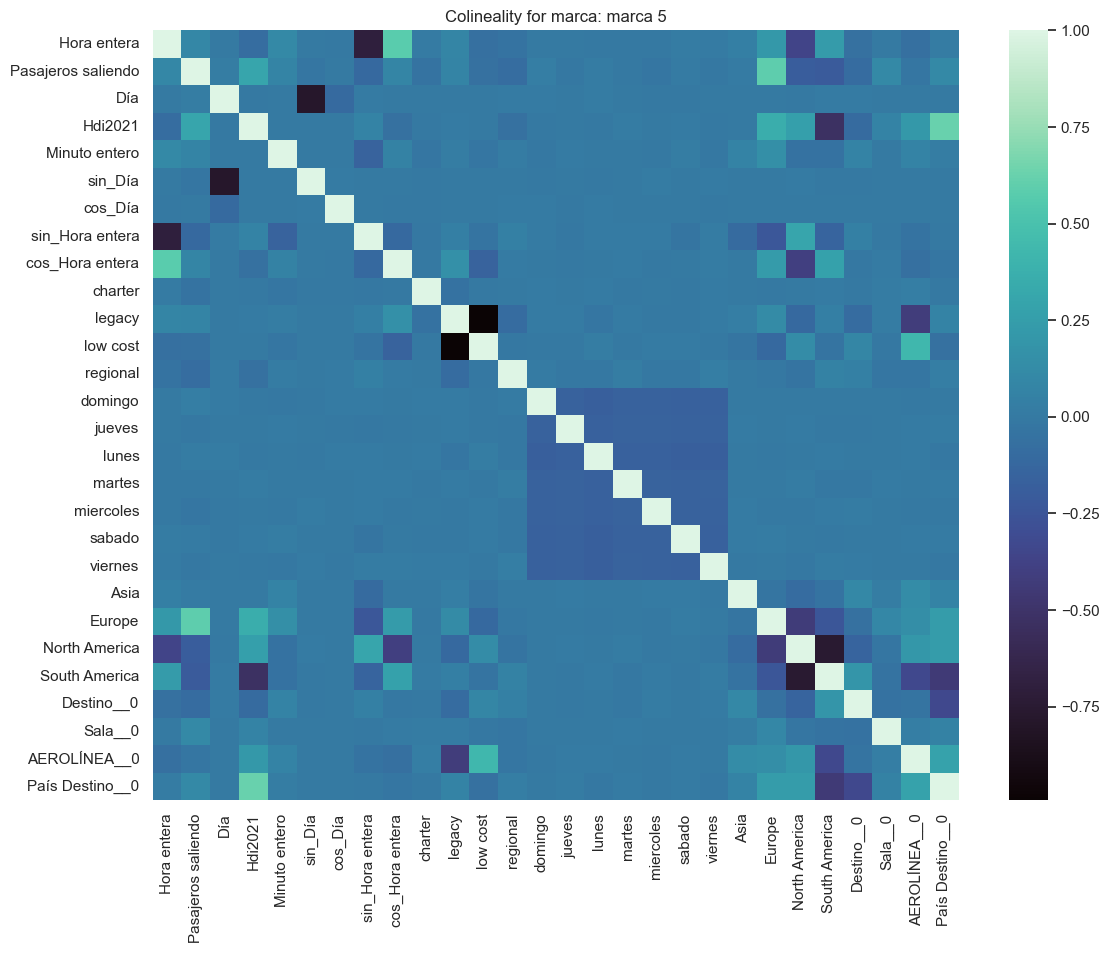

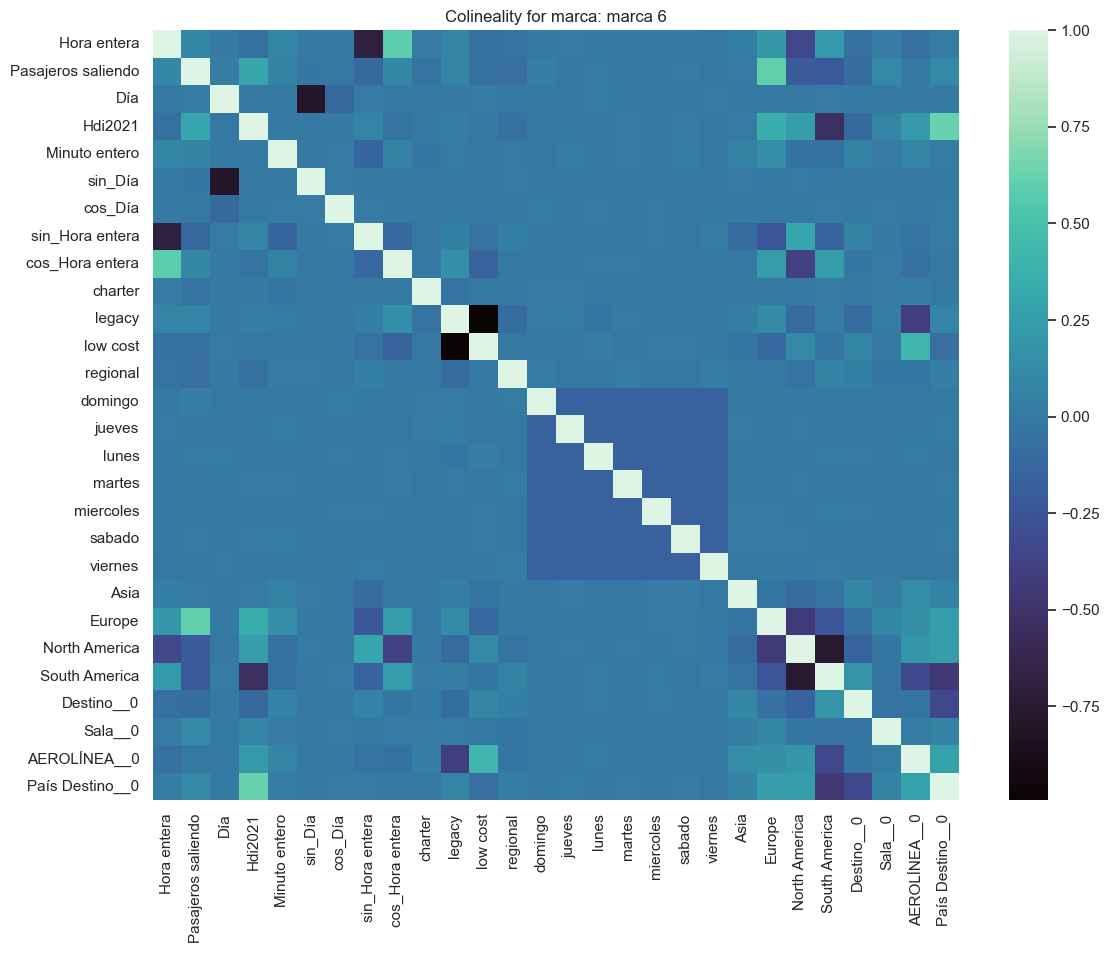

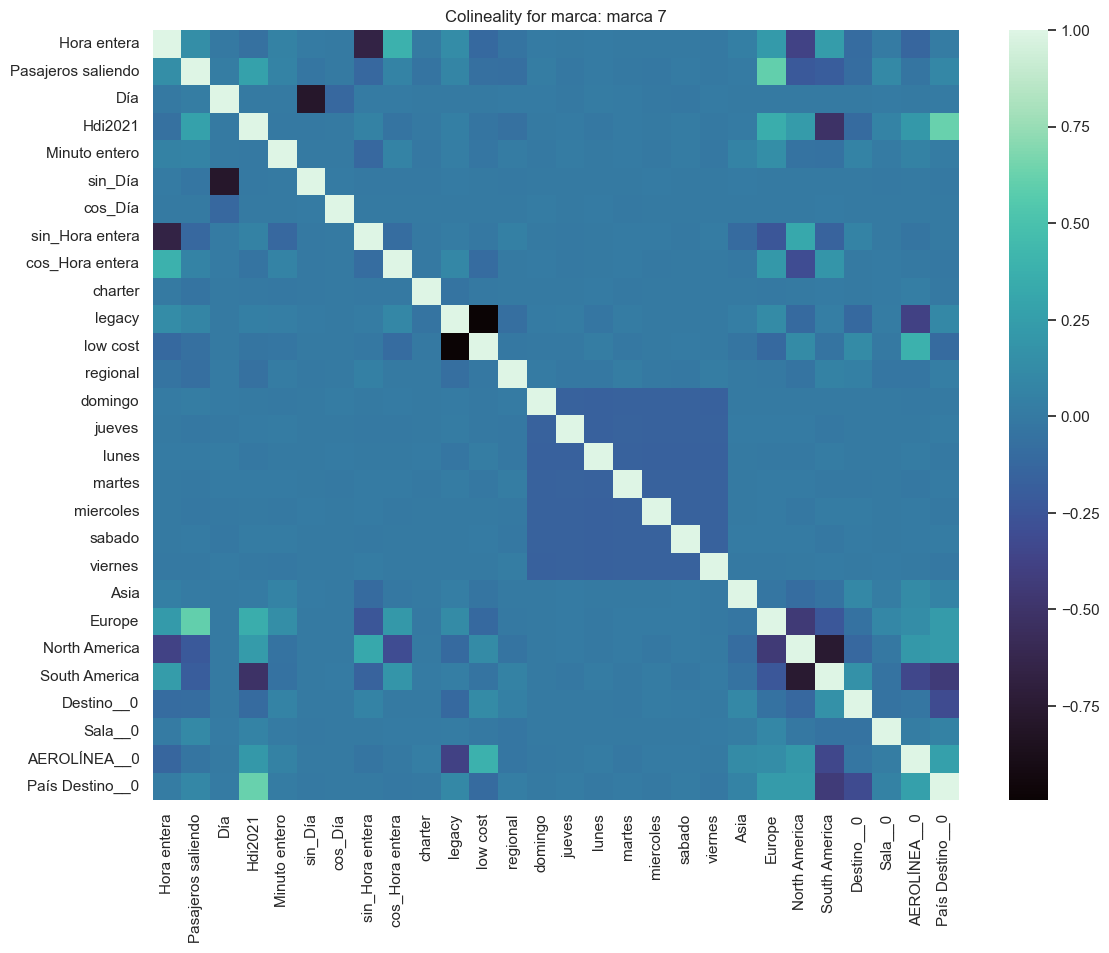

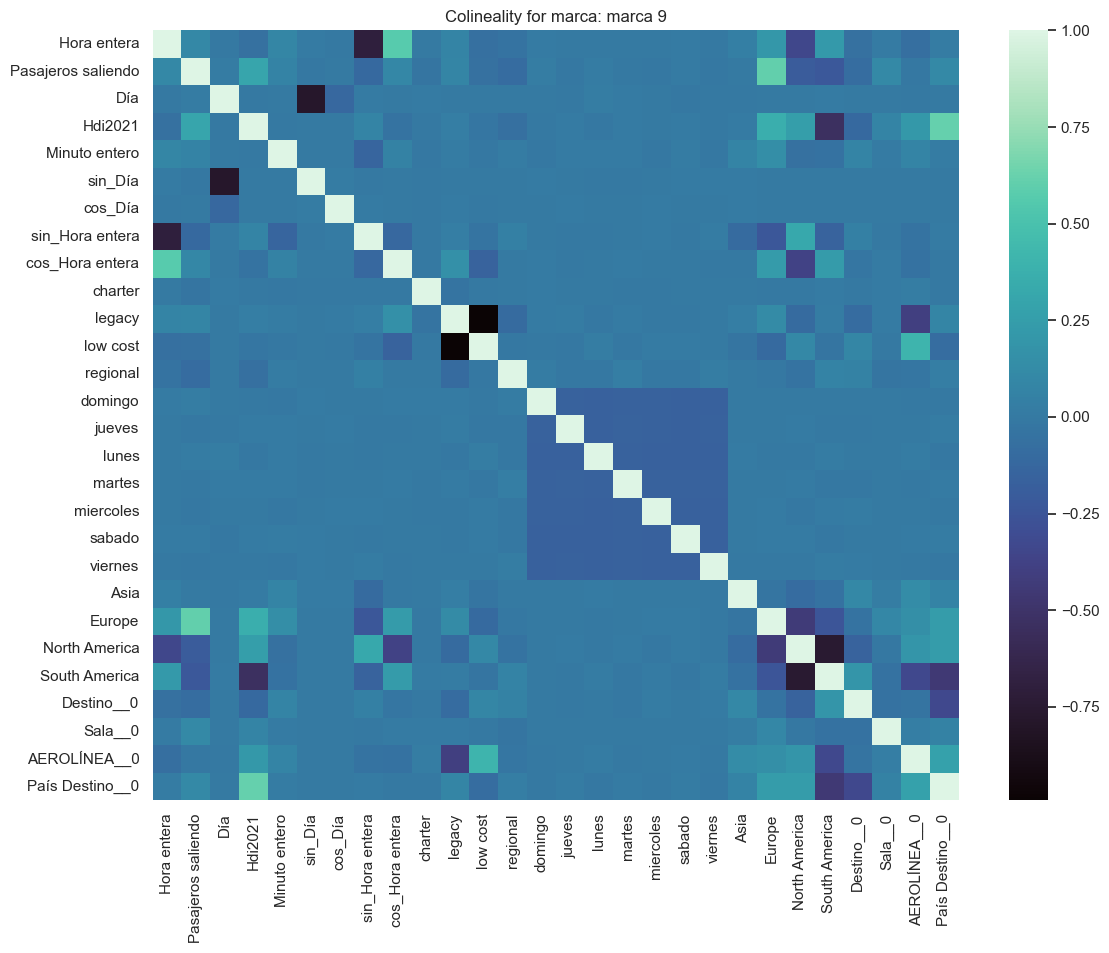

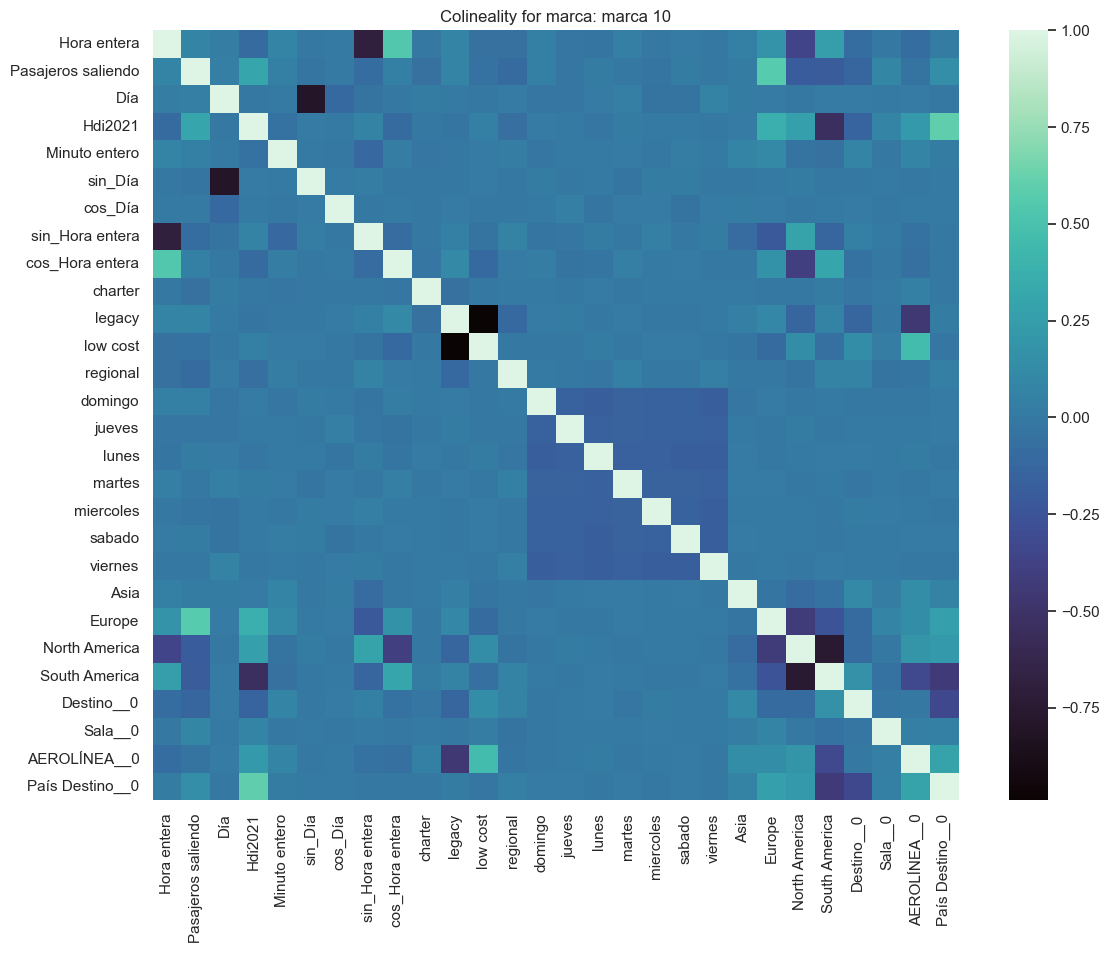

In [25]:
remove_high_colineality_columns(datasets_trans, MAX_COLINEALITY)

In [26]:
for marca, marca_config in datasets_trans.items():
    print(f"Marca {marca} now has {len(marca_config['columns'])} features")

Marca muelle now has 120 features
Marca marca 1 now has 119 features
Marca marca 2 now has 28 features
Marca marca 3 now has 28 features
Marca marca 5 now has 28 features
Marca marca 6 now has 28 features
Marca marca 7 now has 28 features
Marca marca 9 now has 28 features
Marca marca 10 now has 28 features


# Entrenamiento de modelos para hallar features mas relevantes
Como se usan modelos no lineales, se necesita entender la linealidad de las features con la variable de salida por medio de la importancia de las features.

In [26]:
datasets_trans["muelle"]["config"]

{'num_config': 'robustScaler',
 'scat_config': ['oneHotEncoder', '0.05'],
 'lcat_config': ['oneHotEncoder', '0.0'],
 'model': 'lgbmregressor'}

In [27]:
train_base_dataset_models(datasets_trans)

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   3.1s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   7.8s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   9.8s
[CV] END boosting_type=gbdt, learning_rate=0.7087526627753578, max_depth=19, metric=rmse, min_data=95, n_estimators=555, n_jobs=-1, num_leaves=107, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=  34.5s
[CV] END b

 11%|████▌                                    | 1/9 [36:06<4:48:54, 2166.84s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   9.3s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   9.4s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   9.7s
[CV] END boosting_type=gbdt, learning_rate=0.7087526627753578, max_depth=19, metric=rmse, min_data=95, n_estimators=555, n_jobs=-1, num_leaves=107, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=  30.6s
[CV] END b

 22%|████████▋                              | 2/9 [1:07:07<3:51:47, 1986.73s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   8.4s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   8.6s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   8.8s
[CV] END boosting_type=gbdt, learning_rate=0.7087526627753578, max_depth=19, metric=rmse, min_data=95, n_estimators=555, n_jobs=-1, num_leaves=107, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=  29.5s
[CV] END b

 33%|█████████████                          | 3/9 [1:36:52<3:09:27, 1894.57s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   9.4s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   9.5s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   9.2s
[CV] END boosting_type=gbdt, learning_rate=0.7087526627753578, max_depth=19, metric=rmse, min_data=95, n_estimators=555, n_jobs=-1, num_leaves=107, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=  31.7s
[CV] END b

 44%|█████████████████▎                     | 4/9 [2:07:48<2:36:36, 1879.25s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   5.9s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   6.1s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   6.1s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.2s
[CV] END bootstrap=True, max_depth=40, max_featu

 56%|█████████████████████▋                 | 5/9 [2:12:26<1:26:47, 1301.91s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   6.6s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   6.4s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   6.4s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.1s
[CV] END bootstrap=True, max_depth=40, max_featu

 67%|████████████████████████████              | 6/9 [2:17:40<48:18, 966.05s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   7.9s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   7.8s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   7.9s
[CV] END boosting_type=gbdt, learning_rate=0.7087526627753578, max_depth=19, metric=rmse, min_data=95, n_estimators=555, n_jobs=-1, num_leaves=107, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=  29.5s
[CV] END b

 78%|███████████████████████████████▉         | 7/9 [2:46:26<40:28, 1214.45s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   8.3s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   7.8s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   7.7s
[CV] END boosting_type=gbdt, learning_rate=0.7087526627753578, max_depth=19, metric=rmse, min_data=95, n_estimators=555, n_jobs=-1, num_leaves=107, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=  26.4s
[CV] END b

 89%|████████████████████████████████████▍    | 8/9 [3:16:45<23:27, 1407.05s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   2.6s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   2.5s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   2.6s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.7s
[CV] END bootstrap=True, max_depth=40, max_featu

100%|█████████████████████████████████████████| 9/9 [3:18:53<00:00, 1326.00s/it]


In [28]:
datasets_trans["muelle"]["metrics"]

,split,MSE,MAE,R2,MAPE,marca
0,train,1.014778e+16,7.337037e+07,0.846443,1.371856e+20,muelle
0,test,1.701770e+16,9.231405e+07,0.752265,2.519722e+20,muelle


In [29]:
df_no_colineal_metrics = pd.concat(
    [
        marca_config["metrics"]
        for marca, marca_config in datasets_trans.items()
    ]
)
df_no_colineal_metrics

,split,MSE,MAE,R2,MAPE,marca
0,train,1.014778e+16,7.337037e+07,0.846443,1.371856e+20,muelle
0,test,1.701770e+16,9.231405e+07,0.752265,2.519722e+20,muelle
0,train,1.084256e+15,2.405430e+07,0.919181,1.793617e+21,marca 1
0,test,1.898403e+15,3.084915e+07,0.854994,3.278727e+21,marca 1
0,train,3.288416e+14,1.405073e+07,0.735610,5.186849e-01,marca 2
0,test,5.319528e+14,1.766449e+07,0.578247,6.917734e-01,marca 2
0,train,1.022117e+15,2.407330e+07,0.724534,4.201569e-01,marca 3
0,test,1.699982e+15,3.075069e+07,0.529621,4.924857e-01,marca 3
0,train,1.868113e+14,1.007904e+07,0.683191,1.607125e+00,marca 5
0,test,4.456039e+14,1.613383e+07,0.205672,2.559516e+00,marca 5


In [30]:
df_no_colineal_metrics[
    df_no_colineal_metrics["split"] == "test"
].sort_values("marca")

,split,MSE,MAE,R2,MAPE,marca
0,test,1.898403e+15,3.084915e+07,0.854994,3.278727e+21,marca 1
0,test,5.464639e+13,5.262098e+06,0.358177,7.612377e-01,marca 10
0,test,5.319528e+14,1.766449e+07,0.578247,6.917734e-01,marca 2
0,test,1.699982e+15,3.075069e+07,0.529621,4.924857e-01,marca 3
0,test,4.456039e+14,1.613383e+07,0.205672,2.559516e+00,marca 5
0,test,8.555807e+14,2.267582e+07,0.395620,3.782003e+19,marca 6
0,test,4.665594e+13,5.272391e+06,0.323474,2.425540e+21,marca 7
0,test,4.585856e+13,5.312114e+06,0.516476,1.612289e+19,marca 9
0,test,1.701770e+16,9.231405e+07,0.752265,2.519722e+20,muelle


# Entrenamiento de modelos con features que altos coeficientes

Entrenamiento de los modelos para diferentes marcas en el conjunto de datos. Primero, se seleccionan las 20 características principales para cada marca en el conjunto de datos. Luego, se entrenan modelos utilizando estas características seleccionadas. Se realiza un seguimiento de las métricas de rendimiento de cada marca y se muestran las columnas seleccionadas para cada modelo. Finalmente, los modelos resultantes se guardan en el archivo utilizando el módulo de Python "pickle". Entrenamiento, seguimiento y almacenamiento de modelos basados en las mejores características para diferentes marcas en el conjunto de datos.

In [31]:
MARCA_TOP_FEATURES = {
    marca: 20
    for marca in datasets_trans
}

In [32]:
top_features_datasets_trans = train_best_features_models(datasets_trans, MARCA_TOP_FEATURES)

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 25.91it/s]


In [33]:
train_base_dataset_models(top_features_datasets_trans)

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   9.6s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   9.2s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   9.4s
[CV] END boosting_type=gbdt, learning_rate=0.7087526627753578, max_depth=19, metric=rmse, min_data=95, n_estimators=555, n_jobs=-1, num_leaves=107, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=  23.4s
[CV] END b

 11%|████▌                                    | 1/9 [30:34<4:04:36, 1834.56s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   8.8s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   8.4s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   8.6s
[CV] END boosting_type=gbdt, learning_rate=0.7087526627753578, max_depth=19, metric=rmse, min_data=95, n_estimators=555, n_jobs=-1, num_leaves=107, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=  29.2s
[CV] END b

 22%|████████▋                              | 2/9 [1:00:39<3:32:00, 1817.19s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   6.3s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   6.4s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   8.7s
[CV] END boosting_type=gbdt, learning_rate=0.7087526627753578, max_depth=19, metric=rmse, min_data=95, n_estimators=555, n_jobs=-1, num_leaves=107, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=  20.2s
[CV] END b

 33%|█████████████                          | 3/9 [1:26:50<2:50:28, 1704.80s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   7.2s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   8.1s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   8.8s
[CV] END boosting_type=gbdt, learning_rate=0.7087526627753578, max_depth=19, metric=rmse, min_data=95, n_estimators=555, n_jobs=-1, num_leaves=107, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=  27.9s
[CV] END b

 44%|█████████████████▎                     | 4/9 [1:58:41<2:28:50, 1786.20s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   4.9s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   5.4s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   4.8s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.0s
[CV] END bootstrap=True, max_depth=40, max_featu

 56%|█████████████████████▋                 | 5/9 [2:02:57<1:22:17, 1234.46s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   5.5s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   5.3s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   5.6s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.1s
[CV] END bootstrap=True, max_depth=40, max_featu

 67%|████████████████████████████              | 6/9 [2:07:45<45:38, 912.72s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   7.5s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   7.2s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   7.1s
[CV] END boosting_type=gbdt, learning_rate=0.7087526627753578, max_depth=19, metric=rmse, min_data=95, n_estimators=555, n_jobs=-1, num_leaves=107, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=  22.3s
[CV] END b

 78%|███████████████████████████████▉         | 7/9 [2:34:39<38:03, 1141.87s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   9.9s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=  10.2s
[CV] END boosting_type=gbdt, learning_rate=0.1251915381194626, max_depth=45, metric=rmse, min_data=95, n_estimators=288, n_jobs=-1, num_leaves=60, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=   9.8s
[CV] END boosting_type=gbdt, learning_rate=0.7087526627753578, max_depth=19, metric=rmse, min_data=95, n_estimators=555, n_jobs=-1, num_leaves=107, objective=regression, sub_feature=0.4791525604225574, verbose=-1; total time=  28.4s
[CV] END b

 89%|████████████████████████████████████▍    | 8/9 [3:03:11<22:03, 1323.47s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   2.5s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   2.3s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   2.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.6s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.6s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.7s
[CV] END bootstrap=True, max_depth=40, max_featu

100%|█████████████████████████████████████████| 9/9 [3:05:21<00:00, 1235.68s/it]


In [34]:
for marca, marca_config in top_features_datasets_trans.items():
    print(f"Marca {marca} now has {len(marca_config['columns'])} features")

Marca muelle now has 20 features
Marca marca 1 now has 20 features
Marca marca 2 now has 20 features
Marca marca 3 now has 20 features
Marca marca 5 now has 20 features
Marca marca 6 now has 20 features
Marca marca 7 now has 20 features
Marca marca 9 now has 20 features
Marca marca 10 now has 20 features


In [35]:
df_top_feat_metrics = pd.concat(
    [
        marca_config["metrics"]
        for marca, marca_config in top_features_datasets_trans.items()
    ]
)
df_top_feat_metrics

,split,MSE,MAE,R2,MAPE,marca
0,train,1.352875e+16,8.392256e+07,0.795282,1.450629e+20,muelle
0,test,1.771137e+16,9.491571e+07,0.742167,2.260007e+20,muelle
0,train,1.322328e+15,2.634426e+07,0.901435,1.844453e+21,marca 1
0,test,2.107302e+15,3.263340e+07,0.839037,3.168415e+21,marca 1
0,train,4.809963e+14,1.692640e+07,0.613277,5.878964e-01,marca 2
0,test,6.180641e+14,1.909425e+07,0.509975,7.293936e-01,marca 2
0,train,1.261198e+15,2.664156e+07,0.660101,4.492915e-01,marca 3
0,test,1.789233e+15,3.169421e+07,0.504926,4.942062e-01,marca 3
0,train,1.746758e+14,9.679315e+06,0.703772,1.515223e+00,marca 5
0,test,4.319595e+14,1.577834e+07,0.229994,2.478859e+00,marca 5


In [36]:
df_top_feat_metrics[
    df_top_feat_metrics["split"] == "test"
].sort_values("marca")

,split,MSE,MAE,R2,MAPE,marca
0,test,2.107302e+15,3.263340e+07,0.839037,3.168415e+21,marca 1
0,test,5.198622e+13,5.054766e+06,0.389421,7.294447e-01,marca 10
0,test,6.180641e+14,1.909425e+07,0.509975,7.293936e-01,marca 2
0,test,1.789233e+15,3.169421e+07,0.504926,4.942062e-01,marca 3
0,test,4.319595e+14,1.577834e+07,0.229994,2.478859e+00,marca 5
0,test,8.429569e+14,2.230881e+07,0.404538,3.683935e+19,marca 6
0,test,5.054632e+13,5.536650e+06,0.267063,2.652774e+21,marca 7
0,test,4.925996e+13,5.524469e+06,0.480612,1.470789e+19,marca 9
0,test,1.771137e+16,9.491571e+07,0.742167,2.260007e+20,muelle


In [37]:
for marca, marca_config in top_features_datasets_trans.items():
    print("*" * 20)
    print(f"Marca {marca} columns: {marca_config['columns']}")

********************
Marca muelle columns: ['Pasajeros saliendo', 'Día', 'Minuto entero', 'sin_Día', 'cos_Día', 'Hora entera', 'Hdi2021', 'sin_Hora entera', 'cos_Hora entera', 'avianca s a', 'North America', 'domingo', 'miercoles', 'lunes', 'martes', 'sabado', 'South America', 'legacy', 'viernes', 'latam airlines']
********************
Marca marca 1 columns: ['Minuto entero', 'Pasajeros saliendo', 'Hdi2021', 'Día', 'sin_Día', 'Hora entera', 'cos_Día', 'sin_Hora entera', 'cos_Hora entera', 'avianca s a', 'North America', 'miami', 'legacy', 'martes', 'latam airlines', 'domingo', 'lunes', 'South America', 'United States', 'miercoles']
********************
Marca marca 2 columns: ['Pasajeros saliendo', 'Día', 'sin_Día', 'Minuto entero', 'Hora entera', 'cos_Día', 'Hdi2021', 'sin_Hora entera', 'cos_Hora entera', 'Sala__0', 'Destino__0', 'País Destino__0', 'North America', 'AEROLÍNEA__0', 'legacy', 'sabado', 'lunes', 'viernes', 'martes', 'South America']
********************
Marca marca 3 colu

In [40]:
with open(OUTPUT_MODELS_FILE, "wb") as f:
    pickle.dump(top_features_datasets_trans, f)